In [1]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from qml.kernels import gaussian_kernel
import numpy as np


class KRR(BaseEstimator, RegressorMixin):
    
    def __init__(self, kernel_func = None, sigma=None, lamb=None, kpca_ncmps=None, bst_mod = None):



        """
        User must provide a kernelfunction, 
        sigma and lambda are optinal for initialization
        """

        self.kernel_func  = kernel_func or gaussian_kernel       # kernelfunction, no default
        self.sigma        = sigma or 1.0                         # sigma value, 1 default
        self.lamb         = lamb  or 1e-7                        # lambda value, 1e-7 default
        self.kpca_ncmps   = kpca_ncmps or 2                      # number of components for kpca, 2 default
        self.bst_mod      = bst_mod or 0           
        
        
        """
        get_params and set_params are used by sklearn e.g. for hyperparameter
        optimization
        """

    def get_params(self, deep=True):

        return {"kernel_func":self.kernel_func,"sigma": self.sigma, "lamb": self.lamb}

    def set_params(self, **parameters):

        self.kernel_func   = parameters["kernel_func"]
        self.sigma         = parameters["sigma"]
        self.lamb          = parameters["lamb"]      
        
        
        return self

        """
        Obtain the regression coefficients alpha and
        save the training representations because they are 
        needed for predictions
        """
    
    def fit(self, X, y):

        Kernel_train  = self.kernel_func(X,X, self.sigma)

        for i in range(Kernel_train.shape[0]):
            Kernel_train[i, i] += self.lamb

   
        self.ALPHA_SOL = np.linalg.solve(Kernel_train, y)
        self.XTRAIN    = X
        
        self.Kernel_train = Kernel_train
        return self
    
        """
        Make the predictions for query representations Xry
        """

    def predict(self, Xqry):

        Kernel_test     = self.kernel_func(self.XTRAIN, Xqry, self.sigma)
        pred            = np.dot(self.ALPHA_SOL, Kernel_test)
        
        return pred
    
        """
        Make a kernel-pca, by first going to kernel space and 
        performing a pca afterwards, by default 
        returns the first two components
        """

    def kpca(self, X):
        from sklearn.decomposition import PCA

        try:
            
            self.Kernel_train.shape()
            pca     = PCA(n_components=self.kpca_ncmps)
            kpca    = pca.fit_transform(self.Kernel_train)

            print("Used old Kernel for KPCA")

        except:        
            print("Compute new Kernel and store after KPCA")

            self.Kernel_train  = self.kernel_func(X,X, self.sigma)
            pca     = PCA(n_components=self.kpca_ncmps)
            kpca    = pca.fit_transform(self.Kernel_train)        
        
        return kpca

**1 d funktion  Example**

In [9]:
import numpy as np
import numpy.linalg as LA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#import numba
#from numba import jit
#from math import sqrt


#@jit
def fast_distance(xa, xb):

    if len(xa.shape) == 1:
        measure = abs
    else:
        measure = LA.norm


    dmat = np.zeros((len(xa),len(xb) ))

    if np.array_equal(xa, xb):
        for i in range(len(xa)):
            for j in range(i+1, len(xb)):
                curr_d = measure(xa[i]-xb[j])
                dmat[i, j] = curr_d
                dmat[j, i] = curr_d

    else:
        for i in range(len(xa)):
            for j in range(len(xb)):
                curr_d = measure(xa[i]-xb[j])
                dmat[i, j] = curr_d

    return dmat




def kernel_1d_fct_laplace(Xa, Xb, sigma):

    dist = fast_distance(Xa, Xb)
    
    return np.exp(-sigma* dist)


def kernel_1d_fct_gauss(Xa, Xb, sigma):

    dist = fast_distance(Xa, Xb)
    
    return np.exp(-sigma* dist**2)    
    
ndata = 50
X = np.linspace(1, 7, ndata)
# make a function that is complicated to fit and add some noise
y = -5 *np.exp(-X)*np.sin(-X)*np.cos(X**2)   +  np.random.normal(0,1e-8,ndata)


regressor = KRR(kernel_1d_fct_laplace)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7,shuffle=True, random_state=666)
param_grid = [{"krr__sigma": np.logspace(-4, 4, 10), "krr__lamb":np.logspace(-8, -6, 2), "krr__kernel_func": [kernel_1d_fct_laplace,kernel_1d_fct_gauss ]}]
pipe = Pipeline([ ('krr', regressor) ])
grid_search = 0
grid_search = GridSearchCV(pipe, param_grid, cv = 5, return_train_score=True, verbose=1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print(best_model['krr'])
print(best_model['krr'].sigma)
print(best_model['krr'].lamb)
y_pred = best_model['krr'].predict(X_test)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KRR(kernel_func=<function kernel_1d_fct_gauss at 0x7fbdac44cea0>, lamb=1e-08,
    sigma=21.54434690031882)
21.54434690031882
1e-08


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished


## Get the kernel CV optimized kernel paramters

In [10]:
print(best_model.get_params()['krr__kernel_func'])
print(best_model.get_params()['krr__sigma'])
print(best_model.get_params()['krr__lamb'])

<function kernel_1d_fct_gauss at 0x7fbdac44cea0>
21.54434690031882
1e-08


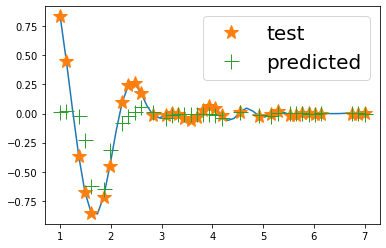

In [11]:
plt.plot(X, y, "-")
plt.plot( X_test, y_test,  "*",ms=15,label='test')
plt.plot( X_test, y_pred,  "+",ms=15,label='predicted')
plt.legend(fontsize=20)

## Perform a KPCA using the kernel

Compute new Kernel and store after KPCA


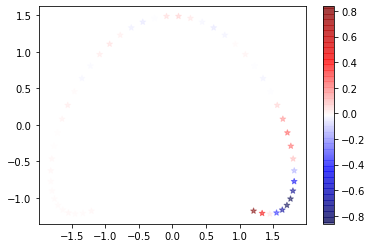

In [8]:
fig, ax = plt.subplots()
regressor.kpca_ncmps = 3
two_dim = regressor.kpca(X)
formation = ax.scatter(two_dim[:,0],two_dim[:,1],marker="*", c=y,vmin=np.min(y), vmax=np.max(y), alpha=0.5, cmap='seismic')
cbar = fig.colorbar(formation, ax=ax)